<a href="https://colab.research.google.com/github/FurqanBhat/GANs/blob/main/GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 50.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch.autograd as autograd

import os




In [ ]:
random_seed=42
torch.manual_seed(random_seed)

BATCH_SIZE=128
AVAIL_GPUS=min(1,torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count()/2)

In [ ]:
class MNISTDataModule(pl.LightningDataModule):

  def __init__(self, data_dir="./data", batch_size=BATCH_SIZE,
               num_workers=NUM_WORKERS):
    super().__init__()
    self.data_dir=data_dir
    self.batch_size=batch_size
    self.num_workers=num_workers

    self.transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,),(0.3081,)),
        ]
    )


  def prepare_data(self):
    MNIST(self.data_dir, train=True, download=True)
    MNIST(self.data_dir, train=False, download=True)


  def setup(self, stage=None):
    #assign trail/val datasets
    if stage == "fit" or stage is None:
      mnist_full=MNIST(self.data_dir, train=True, transform=self.transform)
      self.mnist_train, self.mnist_val=random_split(mnist_full, [55000,5000])

    #assign test datasets
    if stage =="test" or stage is None:
      self.mnist_test=MNIST(self.data_dir, train=False, transform=self.transform)


  def train_dataloader(self):
    return DataLoader(self.mnist_train, self.batch_size, num_workers=self.num_workers)

  def val_dataloader(self):
    return DataLoader(self.mnist_val, self.batch_size, num_workers=self.num_workers)

  def test_dataloader(self):
    return DataLoader(self.mnist_test, self.batch_size, num_workers=self.num_workers)



In [ ]:
class Discriminator(nn.Module):

  def __init__(self):
    super().__init__()
    #simple cnn
    self.conv1=nn.Conv2d(1,10,kernel_size=5)
    self.conv2=nn.Conv2d(10,20, kernel_size=5)
    self.conv2_drop=nn.Dropout2d()
    self.fc1=nn.Linear(320,50)
    self.fc2=nn.Linear(50,1)

  def forward(self, x):
    x=F.relu(F.max_pool2d(self.conv1(x),2)) #(28,28)->(24,24)->(12,12)
    x=F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2)) #(12,12)->(8,8)->(4,4)
    x=x.view(-1, 320)
    x=F.relu(self.fc1(x))
    x=F.dropout(x, training=self.training)
    x=self.fc2(x)
    return torch.sigmoid(x)




In [ ]:
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 64, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]


    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)

        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x) #(n, 64, 7, 7)->(n,32, 16, 16)
        x = F.relu(x)

        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x) #(n,32, 16, 16)->(n,16,34,34)
        x = F.relu(x)

        # Convolution to 28x28 (1 feature map)
        return self.conv(x) #(n,16,34,34)->(n,1,28,28)

In [ ]:
# class GAN(pl.LightningModule):

#   def __init__(self, latent_dim=100, lr=0.0002):
#     super().__init__()

#     self.save_hyperparameters()

#     self.generator=Generator(latent_dim=self.hparams.latent_dim)
#     self.discriminator=Discriminator()

#     #random noise
#     self.validation_z=torch.rand(6, self.hparams.latent_dim)


#   def forward(self, z):
#     return self.generator(z)

#   def adversarial_loss(self, y_hat, y):
#     return F.binary_cross_entropy(y_hat, y)


#   def training_step(self, batch, batch_idx, optimizer_idx):
#     real_imgs, _=batch

#     #sample noise
#     z=torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
#     z=z.type_as(real_imgs)

#     #train generator : max log(D(G(z)))
#     if optimizer_idx == 0:
#       fake_imgs=self(z)
#       y_hat=self.discriminator(fake_imgs)
#       y=torch.ones(real_imgs.size(0), 1)
#       y=y.type_as(real_imgs)

#       g_loss= self.adversarial_loss(y_hat, y)

#       log_dict={"g_loss": g_loss}

#       return {"loss":g_loss, "progress_bar": log_dict, "log":log_dict}


#     #train discriminator: max log(G(x))+log(1-D(G(z)))
#     if optimizer_idx==1:
#       #how well can it label as real
#       y_hat_real=self.discriminator(real_imgs)
#       y_real=torch.ones(real_imgs.size(0), 1)
#       y_real=y_real.type_as(real_imgs)
#       d_real_loss=self.adversarial_loss(y_hat_real, y_real)

#       #how well can it label fake
#       fake_imgs=self(z).detach()
#       y_hat_fake=self.discriminator(fake_imgs)
#       y_fake=torch.zeros(real_imgs.size(0),1)
#       y_fake=y_fake.type_as(real_imgs)
#       d_fake_loss=self.adversarial_loss(y_hat_fake, y_fake)

#       d_loss=(d_real_loss+d_fake_loss)/2

#       log_dict={"d_loss": d_loss}

#       return {"loss":d_loss, "progress_bar": log_dict, "log":log_dict}



#   def configure_optimizers(self):
#     lr=self.hparams.lr
#     optim_g=torch.optim.Adam(self.generator.parameters(), lr=lr)
#     optim_d=torch.optim.Adam(self.discriminator.parameters(), lr=lr)
#     return [optim_g, optim_d], []



#   def plot_imgs(self):
#     z=self.validation_z.type_as(self.generator.lin1.weight)
#     sample_imgs=self.forward(z).cpu()

#     print(f"epoch {self.current_epoch}")
#     fig=plt.figure()
#     for i in range(sample_imgs.size(0)):
#       plt.subplot(2,3,i+1)
#       plt.tight_layout()
#       # Fix: Slice to remove the channel dimension
#       plt.imshow(sample_imgs.detach()[i, 0, :, :], cmap="gray_r", interpolation='none')
#       plt.title('Generated Data')
#       plt.xticks([])
#       plt.yticks([])
#       plt.axis('off')

#     plt.show()

#   def on_epoch_end(self):
#     self.plot_imgs()




In [ ]:
#using manual optimization
class GAN(pl.LightningModule):

  def __init__(self, latent_dim=100, lr=0.0002):
    super().__init__()

    self.save_hyperparameters()

    self.generator=Generator(latent_dim=self.hparams.latent_dim)
    self.discriminator=Discriminator()

    #random noise
    self.validation_z=torch.rand(6, self.hparams.latent_dim)

    # Set to False for manual optimization with multiple optimizers
    self.automatic_optimization = False


  def forward(self, z):
    return self.generator(z)

  def adversarial_loss(self, y_hat, y):
    return F.binary_cross_entropy(y_hat, y)


  # Removed optimizer_idx argument
  def training_step(self, batch, batch_idx):
    # Manually access optimizers
    optim_g, optim_d = self.optimizers()

    real_imgs, _=batch

    #sample noise
    z=torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
    z=z.type_as(real_imgs)

    #train generator : max log(D(G(z)))
    # Zero the generator gradients
    optim_g.zero_grad()
    fake_imgs=self(z)
    y_hat=self.discriminator(fake_imgs)
    y=torch.ones(real_imgs.size(0), 1)
    y=y.type_as(real_imgs)

    g_loss= self.adversarial_loss(y_hat, y)

    # Manual backward pass for generator
    self.manual_backward(g_loss)
    # Step the generator optimizer
    optim_g.step()


    #train discriminator: max log(G(x))+log(1-D(G(z)))
    # Zero the discriminator gradients
    optim_d.zero_grad()
    #how well can it label as real
    y_hat_real=self.discriminator(real_imgs)
    y_real=torch.ones(real_imgs.size(0), 1)
    y_real=y_real.type_as(real_imgs)
    d_real_loss=self.adversarial_loss(y_hat_real, y_real)

    #how well can it label fake
    fake_imgs=self(z).detach()
    y_hat_fake=self.discriminator(fake_imgs)
    y_fake=torch.zeros(real_imgs.size(0),1)
    y_fake=y_fake.type_as(real_imgs)
    d_fake_loss=self.adversarial_loss(y_hat_fake, y_fake)

    d_loss=(d_real_loss+d_fake_loss)/2

    # Manual backward pass for discriminator
    self.manual_backward(d_loss)
    # Step the discriminator optimizer
    optim_d.step()

    # Log losses
    self.log_dict({"g_loss": g_loss, "d_loss": d_loss}, prog_bar=True)


  def configure_optimizers(self):
    lr=self.hparams.lr
    optim_g=torch.optim.Adam(self.generator.parameters(), lr=lr)
    optim_d=torch.optim.Adam(self.discriminator.parameters(), lr=lr)
    return [optim_g, optim_d], []


  def plot_imgs(self):
    print("plot_imgs called")
    z=self.validation_z.type_as(self.generator.lin1.weight)
    sample_imgs=self.forward(z).cpu()

    print(f"epoch {self.current_epoch}")
    fig=plt.figure()
    for i in range(sample_imgs.size(0)):
      plt.subplot(2,3,i+1)
      plt.tight_layout()
      plt.imshow(sample_imgs.detach()[i, 0, :, :], cmap="gray_r", interpolation='none')
      plt.title('Generated Data')
      plt.xticks([])
      plt.yticks([])
      plt.axis('off')

    plt.show()

  def on_epoch_end(self):
    print("onepcohcend")
    self.plot_imgs()

  def on_train_epoch_end(self):
    print("training_epoch_end called")
    self.on_epoch_end()


In [ ]:
dm=MNISTDataModule()
model1=GAN()


plot_imgs called
epoch 0


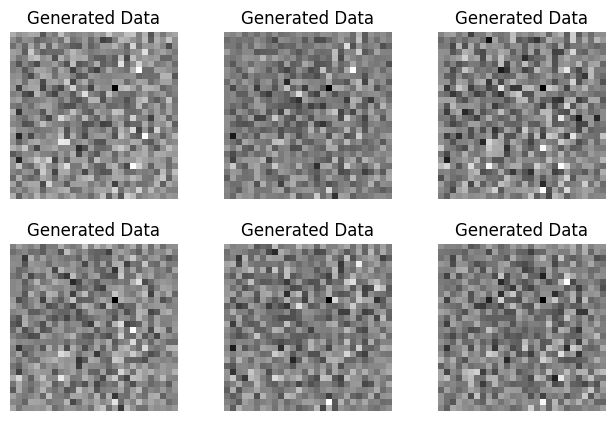

In [ ]:
model1.plot_imgs()

In [ ]:
trainer=pl.Trainer(max_epochs=40, accelerator="gpu", devices=AVAIL_GPUS)

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
100%|██████████| 9.91M/9.91M [00:13<00:00, 719kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 58.3kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 245kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.02MB/s]
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 358 K  | train
1 | discriminator | Discriminator | 21.4 K | train
--------------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

training_epoch_end called
onepcohcend
plot_imgs called
epoch 0


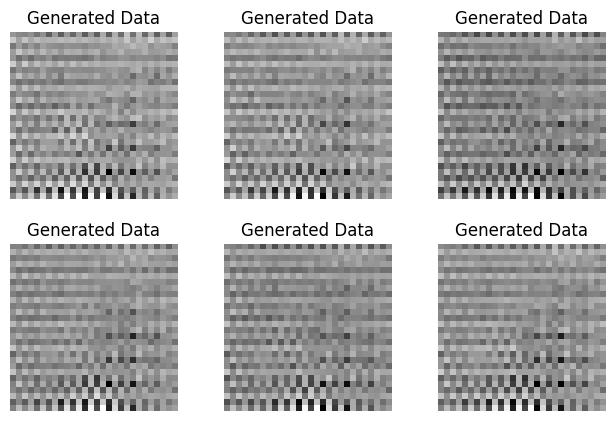

training_epoch_end called
onepcohcend
plot_imgs called
epoch 1


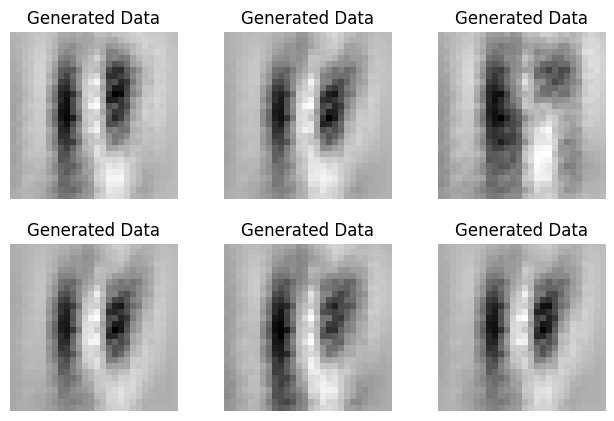

training_epoch_end called
onepcohcend
plot_imgs called
epoch 2


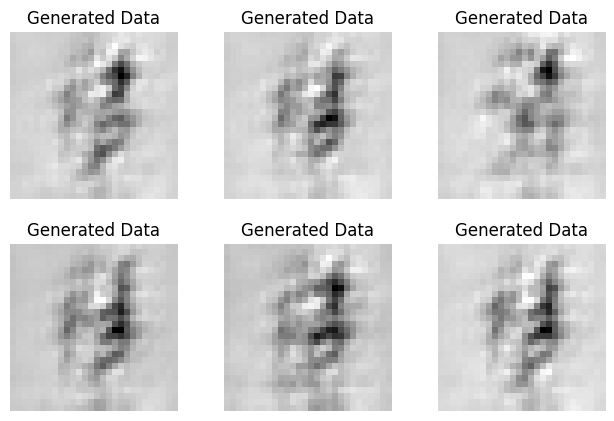

training_epoch_end called
onepcohcend
plot_imgs called
epoch 3


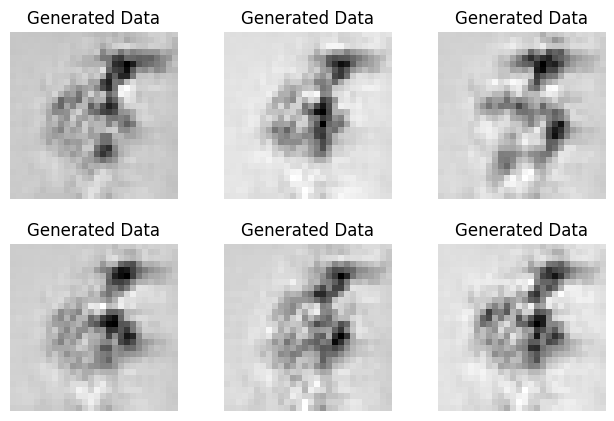

training_epoch_end called
onepcohcend
plot_imgs called
epoch 4


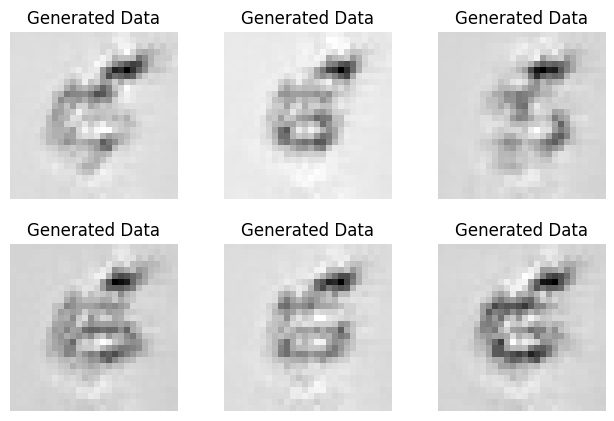

training_epoch_end called
onepcohcend
plot_imgs called
epoch 5


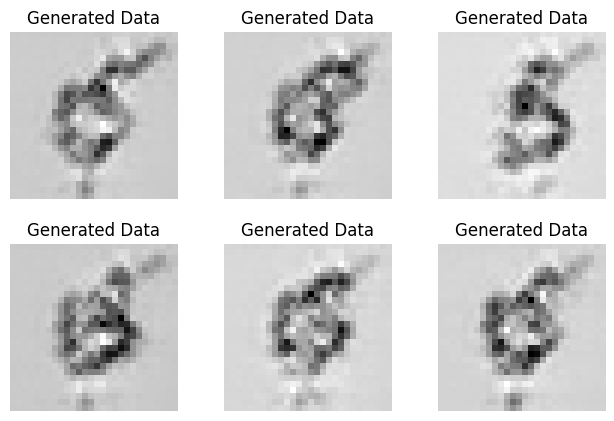

training_epoch_end called
onepcohcend
plot_imgs called
epoch 6


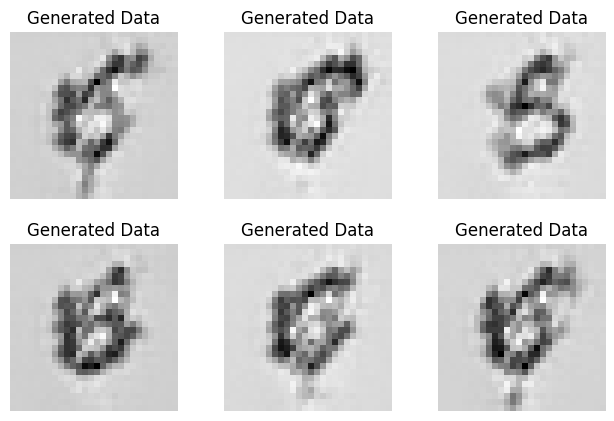

training_epoch_end called
onepcohcend
plot_imgs called
epoch 7


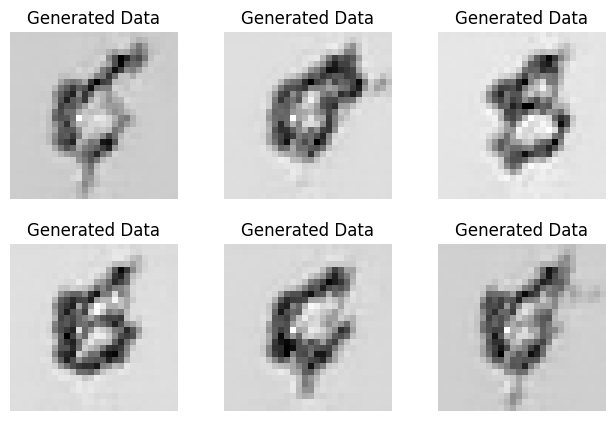

training_epoch_end called
onepcohcend
plot_imgs called
epoch 8


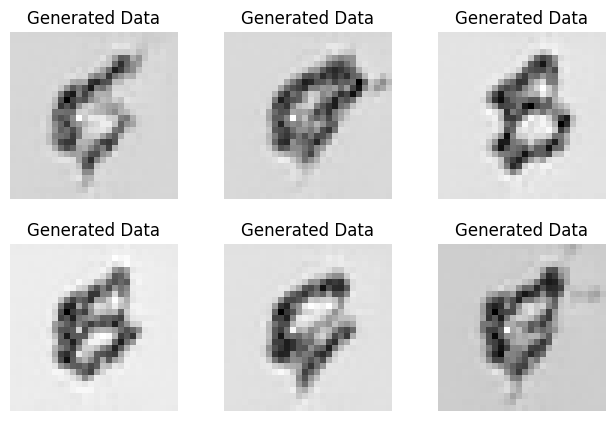

training_epoch_end called
onepcohcend
plot_imgs called
epoch 9


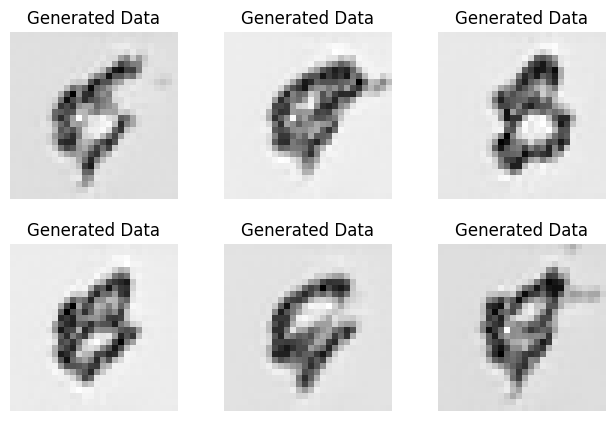

training_epoch_end called
onepcohcend
plot_imgs called
epoch 10


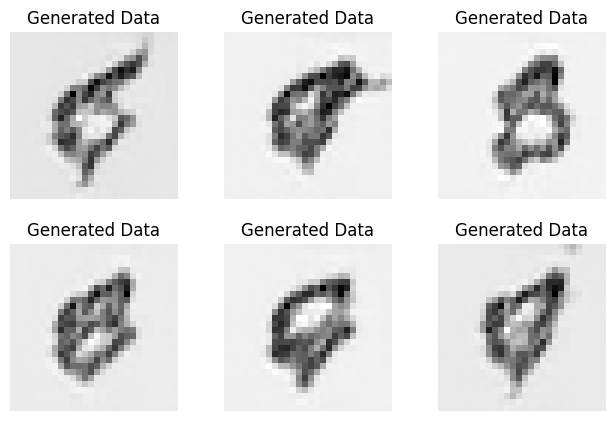

training_epoch_end called
onepcohcend
plot_imgs called
epoch 11


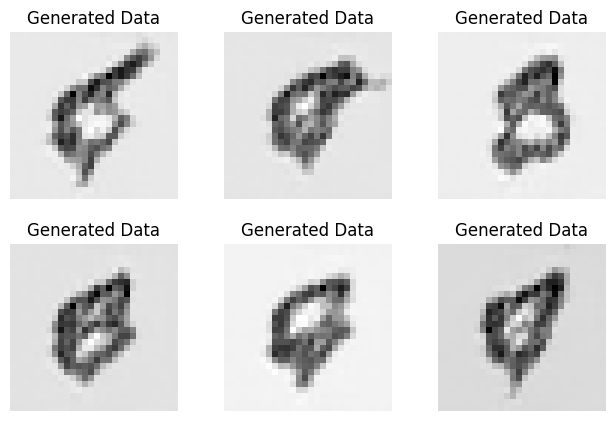

training_epoch_end called
onepcohcend
plot_imgs called
epoch 12


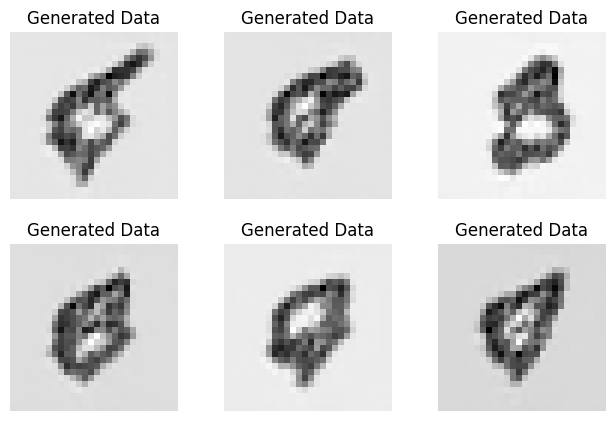

training_epoch_end called
onepcohcend
plot_imgs called
epoch 13


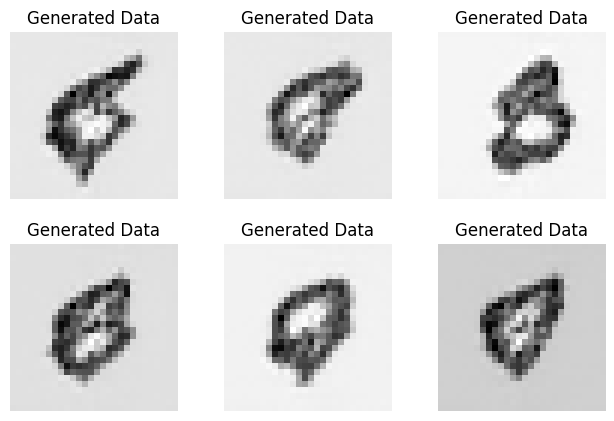

training_epoch_end called
onepcohcend
plot_imgs called
epoch 14


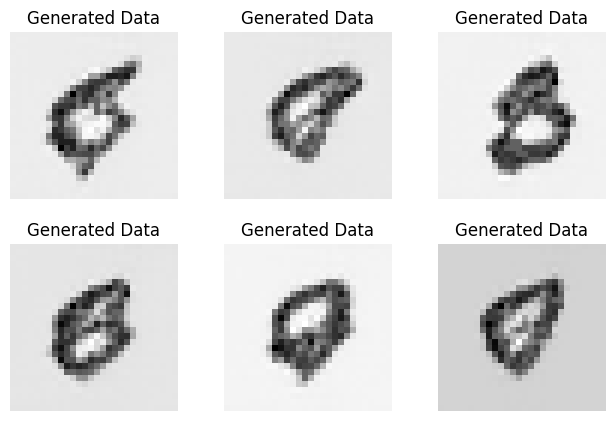

training_epoch_end called
onepcohcend
plot_imgs called
epoch 15


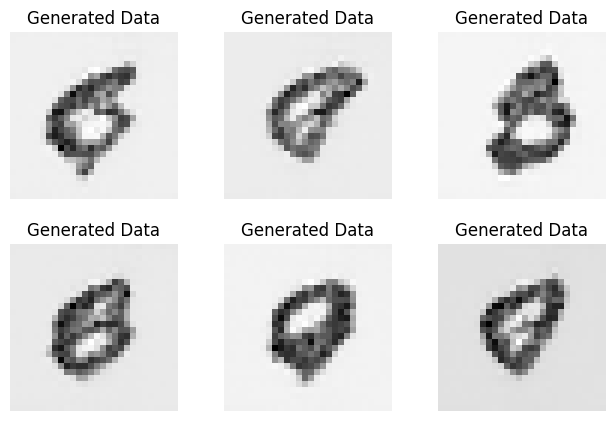

training_epoch_end called
onepcohcend
plot_imgs called
epoch 16


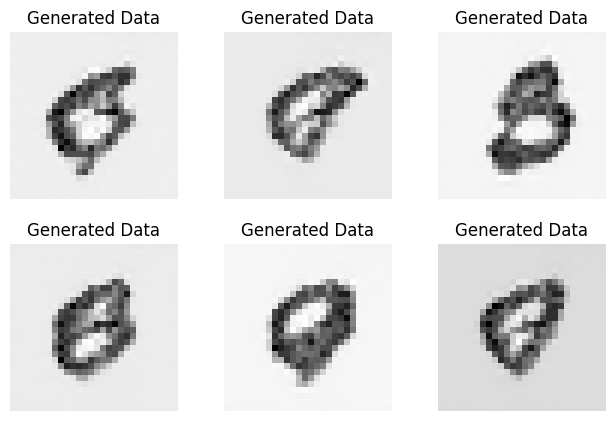

training_epoch_end called
onepcohcend
plot_imgs called
epoch 17


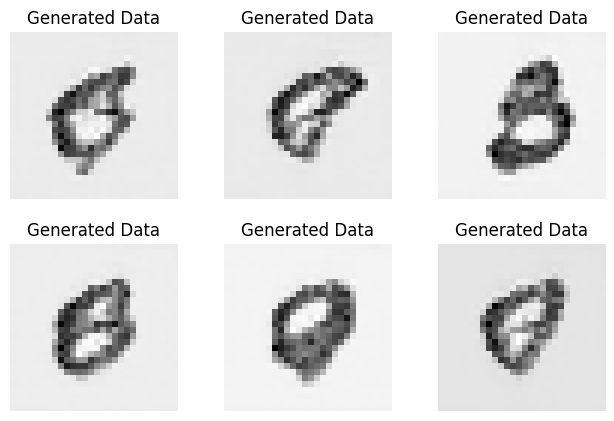

training_epoch_end called
onepcohcend
plot_imgs called
epoch 18


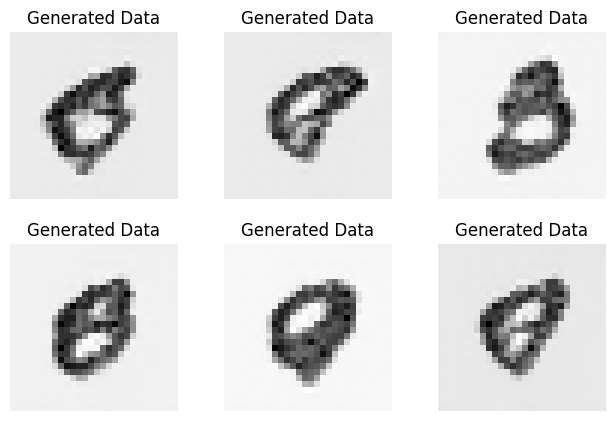

training_epoch_end called
onepcohcend
plot_imgs called
epoch 19


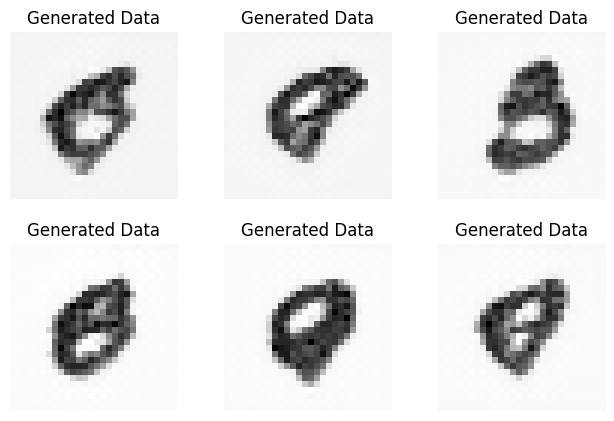

training_epoch_end called
onepcohcend
plot_imgs called
epoch 20


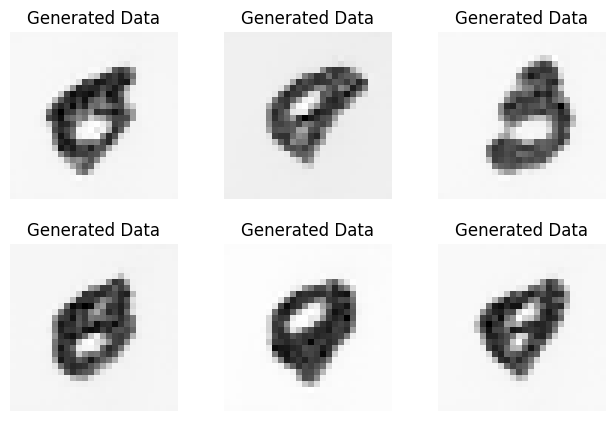

training_epoch_end called
onepcohcend
plot_imgs called
epoch 21


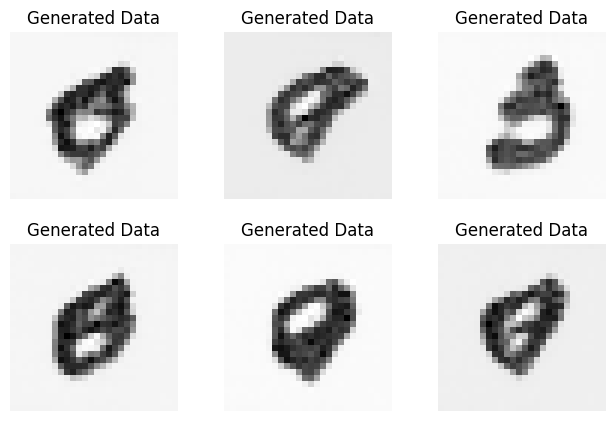

training_epoch_end called
onepcohcend
plot_imgs called
epoch 22


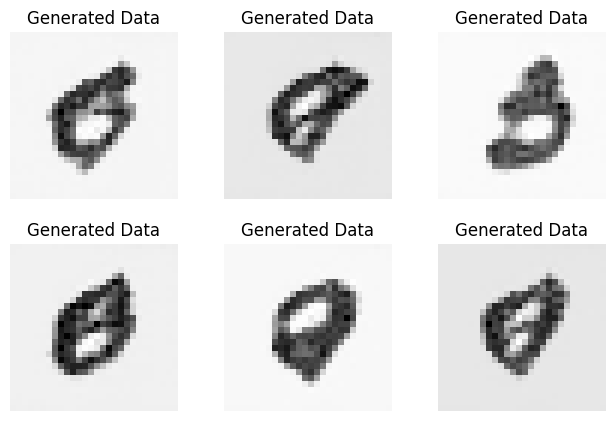

training_epoch_end called
onepcohcend
plot_imgs called
epoch 23


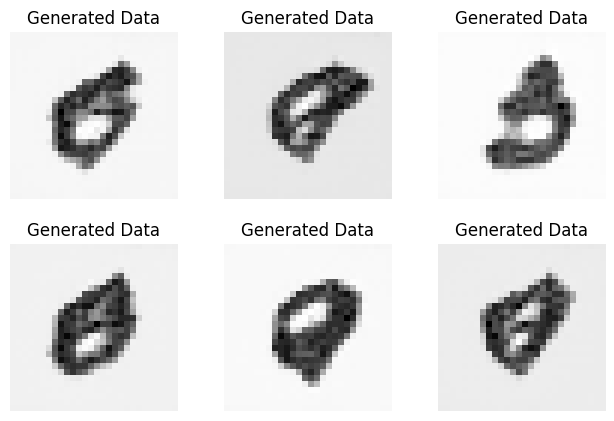

training_epoch_end called
onepcohcend
plot_imgs called
epoch 24


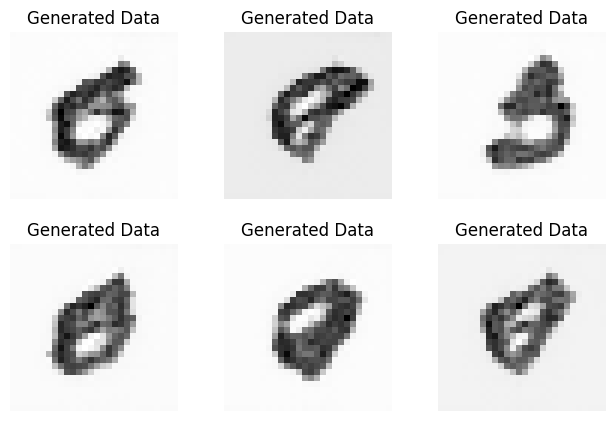

training_epoch_end called
onepcohcend
plot_imgs called
epoch 25


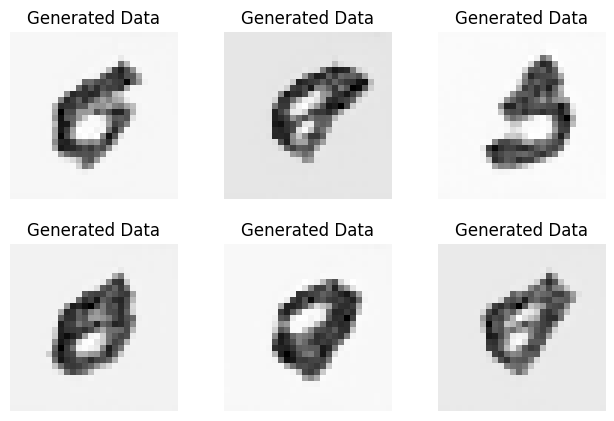

training_epoch_end called
onepcohcend
plot_imgs called
epoch 26


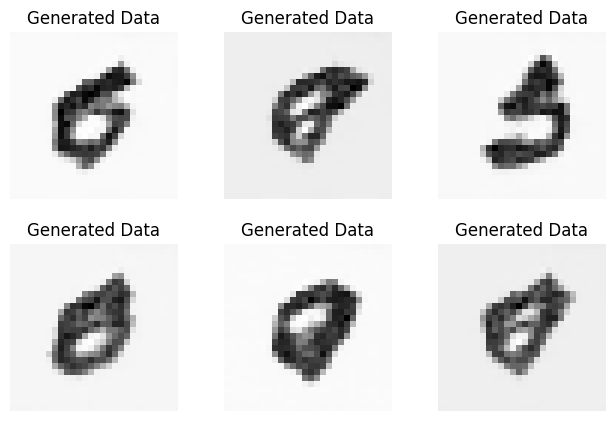

training_epoch_end called
onepcohcend
plot_imgs called
epoch 27


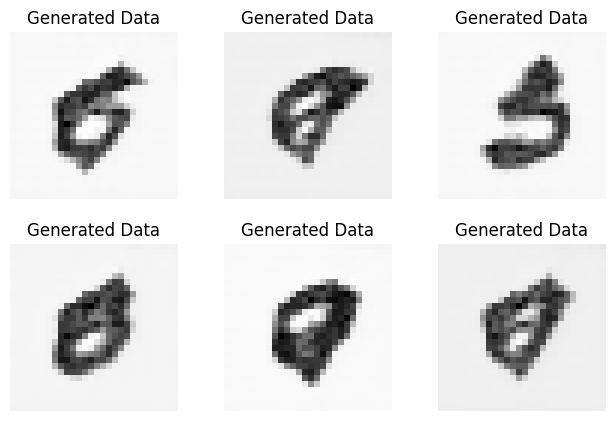

training_epoch_end called
onepcohcend
plot_imgs called
epoch 28


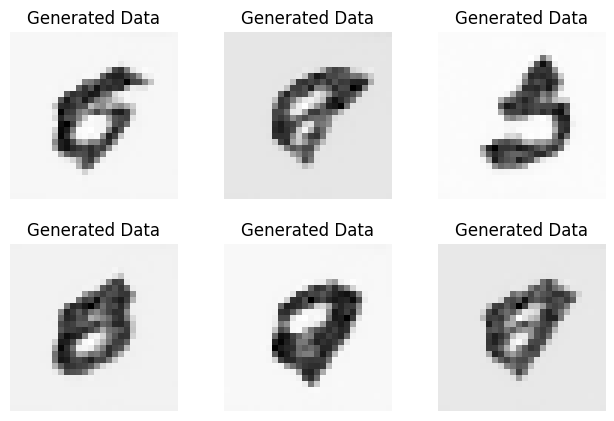

training_epoch_end called
onepcohcend
plot_imgs called
epoch 29


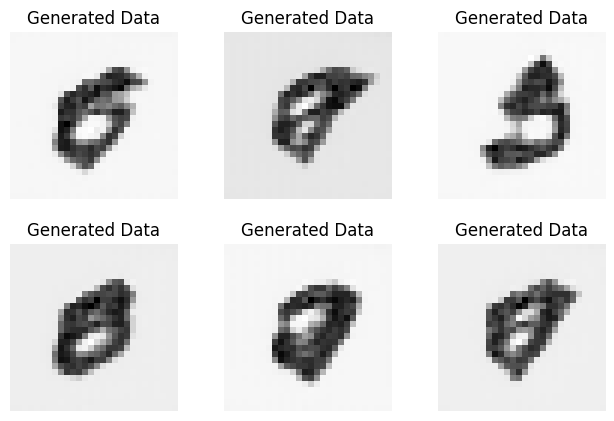

training_epoch_end called
onepcohcend
plot_imgs called
epoch 30


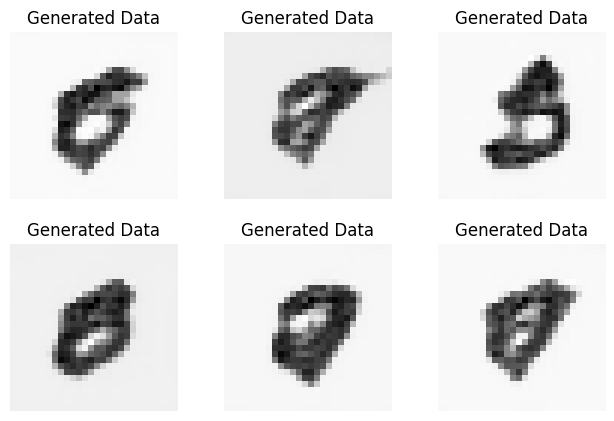

training_epoch_end called
onepcohcend
plot_imgs called
epoch 31


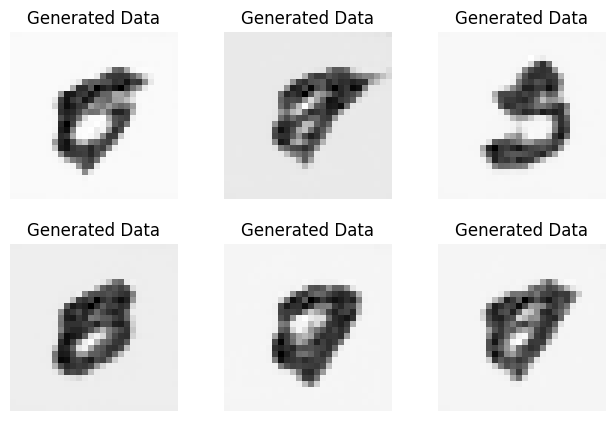

training_epoch_end called
onepcohcend
plot_imgs called
epoch 32


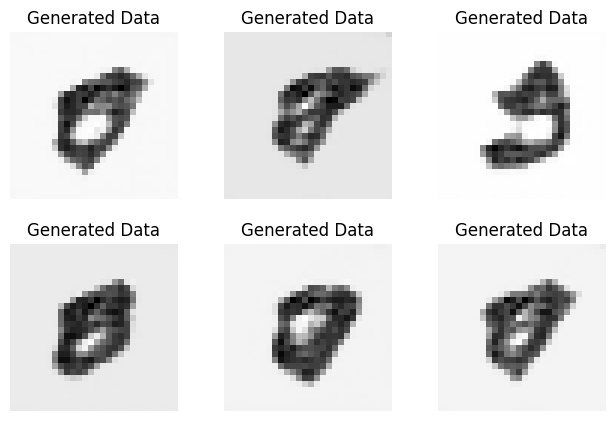

training_epoch_end called
onepcohcend
plot_imgs called
epoch 33


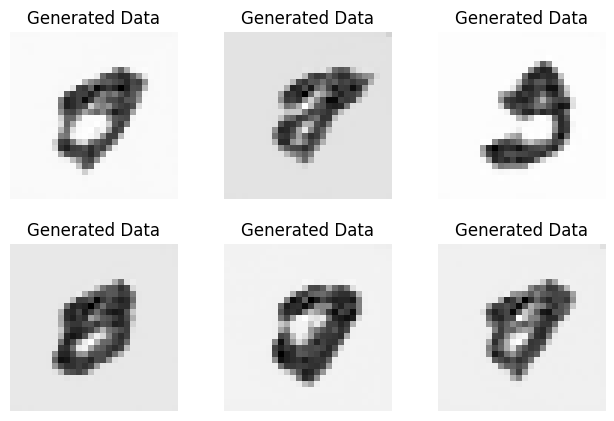

training_epoch_end called
onepcohcend
plot_imgs called
epoch 34


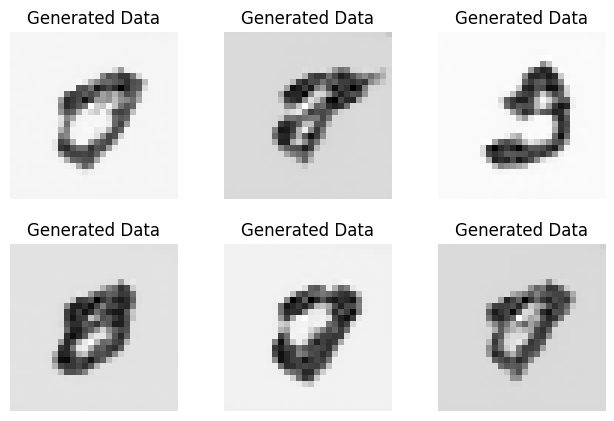

training_epoch_end called
onepcohcend
plot_imgs called
epoch 35


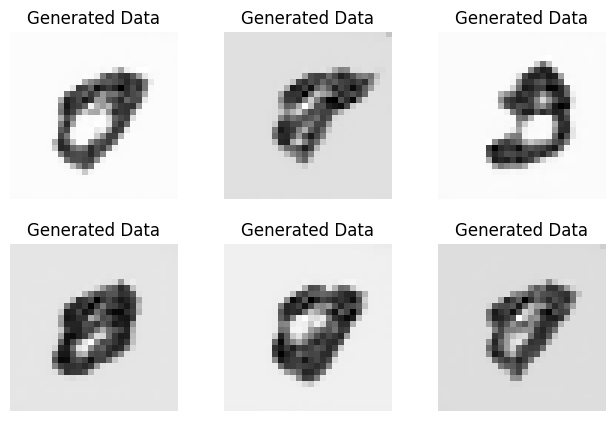

training_epoch_end called
onepcohcend
plot_imgs called
epoch 36


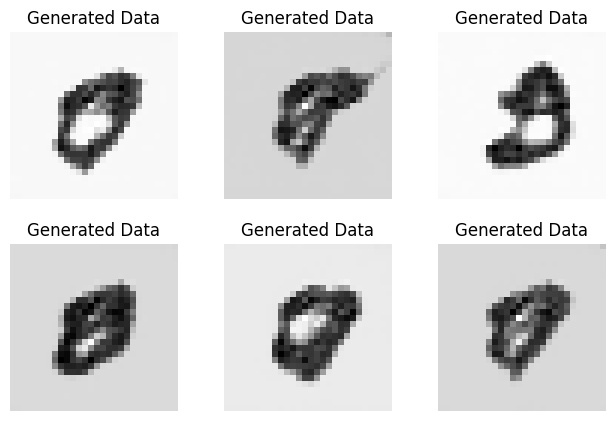

training_epoch_end called
onepcohcend
plot_imgs called
epoch 37


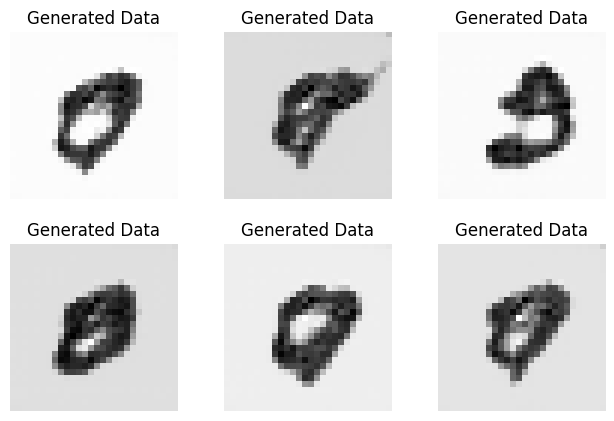

training_epoch_end called
onepcohcend
plot_imgs called
epoch 38


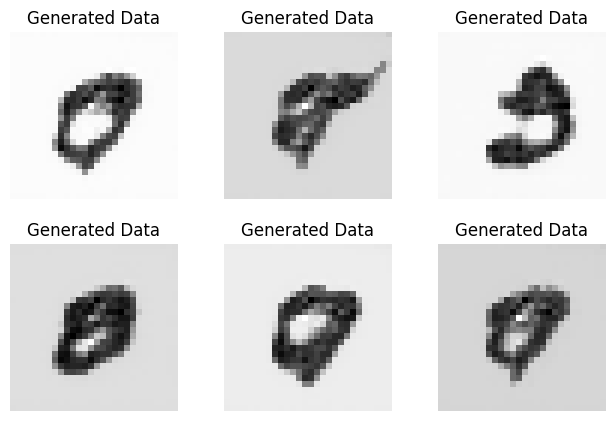

training_epoch_end called
onepcohcend
plot_imgs called
epoch 39


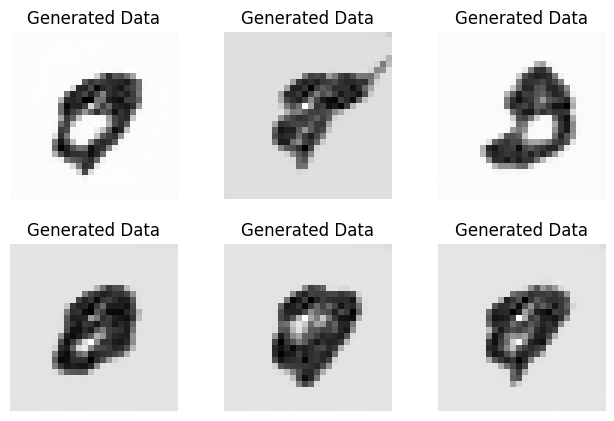

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


In [ ]:
trainer.fit(model1, dm)